# Initial Settings

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
path = '/content/gdrive/My Drive/Outsourcing/DACON/ACOUSTIC/'

import os
os.chdir(path)

Mounted at /content/gdrive/



# Library

In [2]:
import os
import random
import librosa
import numpy as np
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
import cv2

from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.signal import stft
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

# EDA (Exploratory Data Analysis)

### 0. 데이터 로드

In [ ]:
data_path = '/content/gdrive/MyDrive/Outsourcing/DACON/ACOUSTIC/DATASET/'

train_path = os.path.join(data_path, 'train.csv')
test_path = os.path.join(data_path, 'test.csv')

train_df = pd.read_csv(train_path) # 모두 정상 Sample
test_df = pd.read_csv(test_path)

file_names = train_df['SAMPLE_ID'].tolist()
fan_types = train_df['FAN_TYPE'].tolist()

signal_arr = []
outlier_signal = []
sample_rates = np.array([])
for num, file_name in tqdm(enumerate(file_names), total=len(file_names)):
  wave_path = osp.join(data_path, 'train', f'{file_name}.wav')

  y, sr = librosa.load(wave_path, sr=None)

  if len(y) != 10 * sr:
    outlier_signal.append(y)
  else:
    signal_arr.append(y)

  sample_rates = np.concatenate([sample_rates, [sr]])


### 0-1. 신호 데이터 npy로 저장

In [ ]:
# 일일히 wave 파일을 읽어서 분석하는 데 시간이 걸려 신호를 npy로 저장.
signal_arr = np.reshape(signal_arr, (-1, sr*10))
signal_arr.shape
np.save('train_dataset.npy', signal_arr)

### 0-2. npy 신호 데이터 로드

In [4]:
train_dataset = np.load('train_dataset.npy')
sample_rates = np.array([int(data.shape[0]/10) for data in train_dataset])

### 1. Time Domain에서 신호 분석

In [5]:
check_sr = np.where(sample_rates != 16000.)[0]
if len(check_sr) == 0:
  print("모두 sampling rate가 16000 Hz이다.") # 초당 샘플링 횟수가 16000번이다.

  indices = [idx for idx, sample in enumerate(train_dataset) if len(sample) != 16000*10]
  if len(indices) != 0:
    print(f'10초 짜리 신호가 아니다! 10초짜리 신호가 아닌 index: {indices}')

# sampled_signal = np.array([sample for sample in train_dataset if len(sample) == 16000*10])
# sampled_signal.shape # 10초짜리 신호의 개수를 알 수 있다.
print('10초짜리 데이터 개수: ', train_dataset.shape[0])

모두 sampling rate가 16000 Hz이다.
10초짜리 데이터 개수:  1277


### 2. Frequency Domain에서 신호 분석

주파수 성분의 크기:  [0.08219413 0.08583924 0.0825902  ... 0.1028138  0.0825902  0.08583924]
159330 / 160000


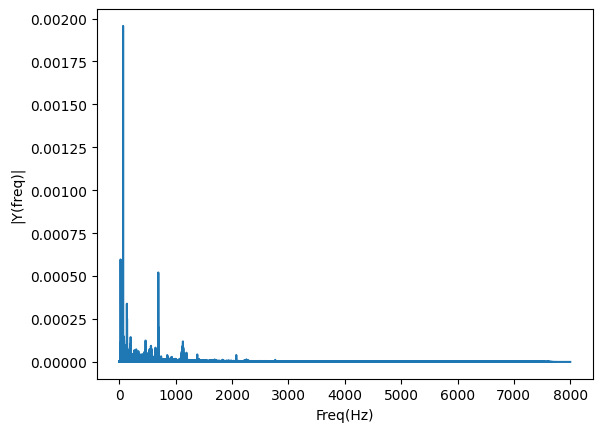

신호들의 최대 주파수:  [7999.9 7999.9 7999.9 ... 7999.9 7999.9 7999.9]
신호들의 최소 주파수:  [0.1 0.1 0.1 ... 0.1 0.1 0.1]


In [6]:
show_freq = False

num = 392
results = np.fft.fft(train_dataset[num]) # 임의의 한 신호를 추출해서 보자.
mag = np.abs(results) ** 2
print('주파수 성분의 크기: ', mag) # 주파수 성분의 크기가 크다는 것은 매우 강한 진폭을 갖고 있다는 것을 의미.
max_idx = np.argmax(mag)
print(f'{max_idx} / {len(mag)}') # 16만 길이의 신호에서 3316번째에서 신호의 진폭이 가장 크다.

sig_length = len(train_dataset[num])
frequencies = np.fft.fftfreq(sig_length, d= 1 / sample_rates[num])
frequencies = frequencies[1:len(frequencies) // 2] # 음수에 해당하는 주파수 성분 제거
Y = results / sig_length
Y = Y[1:len(Y) // 2]   # 한번 진동하는데 1/16000초

if show_freq:
  plt.plot(frequencies, abs(Y))
  plt.xlabel('Freq(Hz)')
  plt.ylabel('|Y(freq)|')
  plt.show()


max_freq = np.array([], dtype=np.float32)
min_freq = np.array([], dtype=np.float32)
for sample in train_dataset:
  results = np.fft.fft(sample)
  mag = np.abs(results) ** 2

  sig_length = len(sample)
  frequencies = np.fft.fftfreq(sig_length, d=1/sample_rates[num])
  frequencies = frequencies[1:len(frequencies) // 2]

  max_freq = np.concatenate([max_freq, [max(frequencies)]])
  min_freq = np.concatenate([min_freq, [min(frequencies)]])

print('신호들의 최대 주파수: ', max_freq)
print('신호들의 최소 주파수: ', min_freq)


In [ ]:
# 신호의 주파수 세기가 가장 큰 값을 갖는 주파수들 찾기.
max_mag_freq = []
for sample in train_dataset:
  results = np.fft.fft(sample)
  # mag = np.abs(results) ** 2

  sig_length = len(sample)
  frequencies = np.fft.fftfreq(sig_length, d=1/sample_rates[num])
  frequencies = frequencies[1:len(frequencies) // 2]

  Y = results / sig_length
  Y = Y[1:len(Y) // 2]   # 한번 진동하는데 1/16000초

  max_mag_freq.append(frequencies[np.argmax(Y)])

1213 1192.5


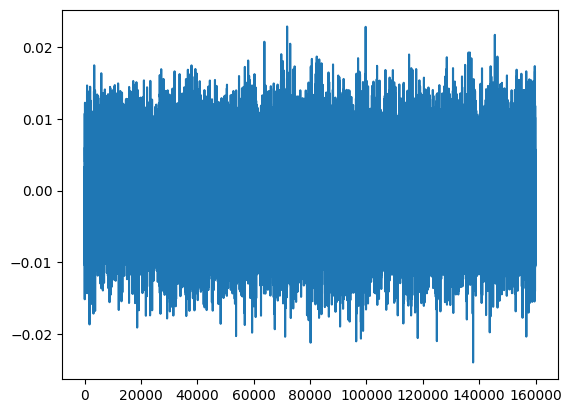

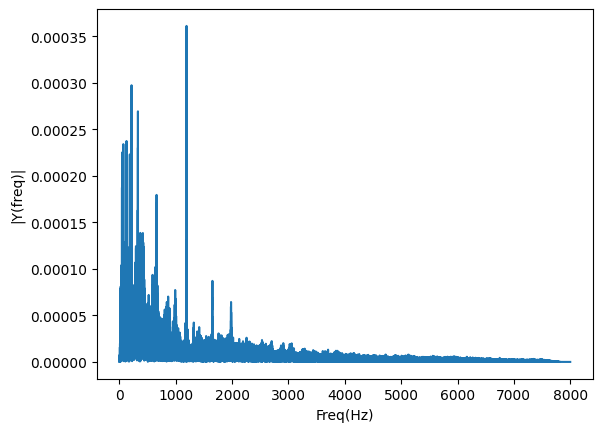

In [ ]:
print(np.argmax(max_mag_freq), max(max_mag_freq))
plt.plot(train_dataset[np.argmax(max_mag_freq)])
plt.show()

results = np.fft.fft(train_dataset[np.argmax(max_mag_freq)])
mag = np.abs(results) ** 2

sig_length = len(train_dataset[np.argmax(max_mag_freq)])
frequencies = np.fft.fftfreq(sig_length, d=1/sample_rates[num])
frequencies = frequencies[1:len(frequencies) // 2]

Y = results / sig_length
Y = Y[1:len(Y) // 2]   # 한번 진동하는데 1/16000초
plt.plot(frequencies, abs(Y))
plt.xlabel('Freq(Hz)')
plt.ylabel('|Y(freq)|')
plt.show()
# 신호 전체에 FFT를 수행할 경우 단점이 있다.
# 신호 전체에 FFT를 수행하면 시간대별로 완전히 다른 주파수 특성을 다 반영하지 못한다.
# 왜냐하면 FFT는 주파수 특성만을 보여주기 때문이다.

### 3. Time - Frequency Domain에서 신호 분석 (STFT)

In [4]:
def stft_to_mel(signal, sample_rate, min=None, max=None):
  """
  STFT 함수를 이용할때 중요한 인자가 있다.
  nperseg: 각 segment의 길이 (Window Size), 주파수 해상도는 주로 윈도우의 크기에 의해 결정됩니다.
           윈도우의 크기가 커질수록 더 많은 주파수 세분성을 얻을 수 있습니다.
           하지만 윈도우 크기를 증가시키면 시간 해상도가 저하될 수 있으므로 이를 고려해야 합니다.
           일반적으로는 주파수와 시간 해상도 간의 균형을 고려하여 적절한 윈도우 크기를 선택해야 합니다.
  noverlap: 오버랩은 인접한 윈도우 사이의 겹침 정도를 나타냅니다.
            오버랩을 증가시키면 각 윈도우 간의 시간 해상도가 향상되어 더 많은 주파수 정보를 얻을 수 있습니다.
            일반적으로 오버랩을 증가시키면 계산 비용이 더 많이 들지만 주파수 해상도가 향상됩니다.
  """
  f, t, Zxx = stft(signal, sample_rate, nperseg=512, noverlap=256)
  """
  f: Frequency axis (주파수 축). STFT의 주파수 영역을 나타낸다.
  t: Time axis (시간 축). 어떤 시간 지점에서 STFT가 계산되었는지 나타낸다.
  Zxx: STFT의 결과, 복소수 형태로 주파수 및 시간에 따른 신호의 주파수 성분을 나타냄.
  """
  Sxx = np.abs(Zxx) # Sxx: 주파수 영역에서 신호 세기를 나타냄. 즉, 주파수의 세기를 나타냄.
  Sxx = np.maximum(Sxx, 1e-8) # 주파수 세기의 최솟값을 1e-8로 제한하겠다.
  mel = 20*np.log10(Sxx) # 주파수의 세기를 dB로 표현.
  # mel = (mel + 160) / 160 # Normalization
  if min is None and max is None:
    return mel
  mel = (mel - min) / (max - min)   # Min-Max Scale Normalization
  """
  Mel은 사람의 청각에 대한 주파수 척도 나타냄.
  낮은 주파수(저주파)에서는 주파수 간격이 넓고 높은 주파수(고주파)에서는 주파수 간격이 좁아지는 것을 반영한다.
  """
  return mel

In [5]:
show_minmax = False
mel_min = np.array([], dtype=np.float32)
mel_max = np.array([], dtype=np.float32)
for num, sample in enumerate(train_dataset):
  mel = stft_to_mel(sample, sample_rates[num])

  mel_min = np.concatenate([mel_min, [mel.min()]])
  mel_max = np.concatenate([mel_max, [mel.max()]])

if show_minmax:
  plt.subplot(2, 1, 1)
  plt.plot(mel_min)
  plt.subplot(2, 1, 2)
  plt.plot(mel_max)



show_stft = False
mel_cand = stft_to_mel(train_dataset[1213], sample_rates[1213], min=np.median(mel_min), max=np.median(mel_max))
mel = stft_to_mel(train_dataset[0], sample_rates[0], min=np.median(mel_min), max=np.median(mel_max))
print(mel.max())
print(mel_cand.max())
if show_stft:
  plt.imshow(mel_cand)
  plt.show()
  plt.imshow(mel)
  plt.show()


0.97908604
0.9814096


### 4. 학습 데이터 만들기

In [ ]:
stft_images = 0
for num, sample in enumerate(train_dataset):
  mel = stft_to_mel(sample, sample_rates[num], min=np.median(mel_min), max=np.median(mel_max))
  # mel = cv2.cvtColor(mel, cv2.COLOR_BGR2RGB)
  mel = mel[np.newaxis, :]
  if num == 0:
    stft_images = mel
    continue

  stft_images = np.concatenate([stft_images, mel], axis=0)

print(stft_images.shape)
np.save('stft_image_dataset.npy', stft_images)

(1277, 257, 626)


#  --------------- 기존 예시 코드 ---------------

In [ ]:
def get_mfcc_feature(df, mode):
    features = []
    idx = 0
    for path in tqdm(df['SAMPLE_PATH']):
        if idx > 100:
          break
        # librosa패키지를 사용하여 wav 파일 load
        wave_name = path.split('/')[-1]
        mdf_path = os.path.join(data_path, mode, wave_name)
        y, sr = librosa.load(mdf_path, sr=CFG['SR'])

        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
        idx += 1
    return features

In [ ]:
train_features = get_mfcc_feature(train_df, mode='train')
test_features = get_mfcc_feature(test_df, mode='test')

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

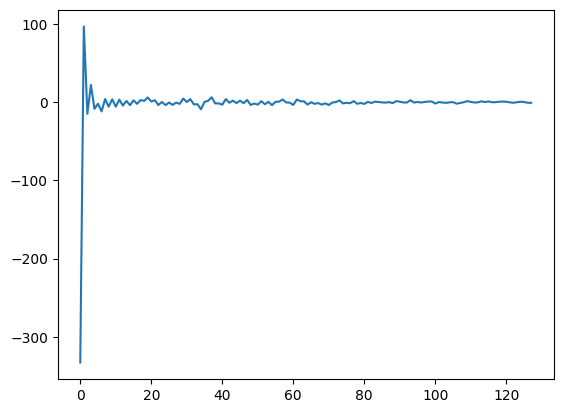

In [ ]:
sample_feature = train_features[0]
import matplotlib.pyplot as plt
plt.plot(sample_feature)

In [ ]:
model = IsolationForest(n_estimators=200, max_samples=256, contamination='auto', random_state=CFG['SEED'], verbose=0)
model.fit(train_features)

IsolationForest(max_samples=256, n_estimators=200, random_state=41)

<!-- Prediction -->

# Prediction

In [ ]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량) 이므로 (0:정상, 1:불량)로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [ ]:
test_pred = model.predict(test_features) # model prediction
test_pred = get_pred_label(test_pred)

In [ ]:
test_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0])